# Projeto integrado - Feature Engineering

# Importações, funções e variaveis auxiliares

In [1]:
#!pip install unidecode
#!pip install feature-engine

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
import unicodedata
import re
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/diogenesjusto/FIAP/master/dados/credit.csv", encoding='unicode_escape',
sep='\t',header=None,index_col="ID_CLIENTE",names=["ID_CLIENTE","TIPO_FUNCIONARIO","DIA_PAGAMENTO","TIPO_ENVIO_APLICACAO","QUANT_CARTOES_ADICIONAIS","TIPO_ENDERECO_POSTAL","SEXO","ESTADO_CIVIL","QUANT_DEPENDENTES","NIVEL_EDUCACIONAL","ESTADO_NASCIMENTO","CIDADE_NASCIMENTO","NACIONALIDADE","ESTADO_RESIDENCIAL","CIDADE_RESIDENCIAL","BAIRRO_RESIDENCIAL","FLAG_TELEFONE_RESIDENCIAL","CODIGO_AREA_TELEFONE_RESIDENCIAL","TIPO_RESIDENCIA","MESES_RESIDENCIA","FLAG_TELEFONE_MOVEL","FLAG_EMAIL","RENDA_PESSOAL_MENSAL","OUTRAS_RENDAS","FLAG_VISA","FLAG_MASTERCARD","FLAG_DINERS","FLAG_AMERICAN_EXPRESS","FLAG_OUTROS_CARTOES","QUANT_CONTAS_BANCARIAS","QUANT_CONTAS_BANCARIAS_ESPECIAIS","VALOR_PATRIMONIO_PESSOAL","QUANT_CARROS","EMPRESA","ESTADO_PROFISSIONAL","CIDADE_PROFISSIONAL","BAIRRO_PROFISSIONAL","FLAG_TELEFONE_PROFISSIONAL","CODIGO_AREA_TELEFONE_PROFISSIONAL","MESES_NO_TRABALHO","CODIGO_PROFISSAO","TIPO_OCUPACAO","CODIGO_PROFISSAO_CONJUGE","NIVEL_EDUCACIONAL_CONJUGE","FLAG_DOCUMENTO_RESIDENCIAL","FLAG_RG","FLAG_CPF","FLAG_COMPROVANTE_RENDA","PRODUTO","FLAG_REGISTRO_ACSP","IDADE","CEP_RESIDENCIAL_3","CEP_PROFISSIONAL_3","ROTULO_ALVO_MAU_1"])

In [4]:
# Variavel para agrupar as colunas em que será aplicado One-Hot Encoding
aplicar_OHE = []
# Variavel para agrupar as colunas em que será aplicado Rare Label Encoding
aplicar_RL = {}
# Variavel para agrupar as colunas em que será aplicado Count Frequency Encoding
aplicar_CF = []

Fazer tratamento em textos

In [5]:
def limpar_texto(texto):    
    # Remove acentuações
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    
    # Remove dígitos
    texto = re.sub(r'\d+', '', texto)
    
    # Remove caracteres especiais e mantém apenas letras e espaços
    texto = re.sub(r'[^a-z\s]', '', texto)
    
    # Remove espaços extras
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto if len(texto)>3 and re.search(r'[aeiou]', texto) else pd.NA

Converter as colunas para categóricas binárias

In [6]:
def converter_para_bool(df, colunas):
    """
    Converte as colunas especificadas para o tipo bool no dataframe automaticamente,
    mapeando os dois valores distintos para True e False.
    
    Parâmetros:
    - df: DataFrame
    - colunas: Lista com os nomes das colunas a serem convertidas
    
    Retorno:
    - DataFrame com as colunas convertidas para booleano
    """
    for coluna in colunas:
        if coluna in df.columns:
            # Obtém os valores únicos da coluna
            valores_unicos = df[coluna].dropna().unique()
            
            # Cria o mapeamento entre os valores únicos e True/False
            mapeamento = {valores_unicos[0]: False, valores_unicos[1]: True}
            df[coluna] = df[coluna].map(mapeamento).astype('bool')

# Análise inicial

In [7]:
df.head()

,TIPO_FUNCIONARIO,DIA_PAGAMENTO,TIPO_ENVIO_APLICACAO,QUANT_CARTOES_ADICIONAIS,TIPO_ENDERECO_POSTAL,SEXO,ESTADO_CIVIL,QUANT_DEPENDENTES,NIVEL_EDUCACIONAL,ESTADO_NASCIMENTO,...,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,PRODUTO,FLAG_REGISTRO_ACSP,IDADE,CEP_RESIDENCIAL_3,CEP_PROFISSIONAL_3,ROTULO_ALVO_MAU_1
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,C,5,Web,0,1,F,6,1,0,RN,...,0,0,0,0,1,N,32,595,595,1
2,C,15,Carga,0,1,F,2,0,0,RJ,...,0,0,0,0,1,N,34,230,230,1
3,C,5,Web,0,1,F,2,0,0,RN,...,0,0,0,0,1,N,27,591,591,0
4,C,20,Web,0,1,F,2,0,0,PE,...,0,0,0,0,1,N,61,545,545,0
5,C,10,Web,0,1,M,2,0,0,RJ,...,0,0,0,0,1,N,48,235,235,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1 to 50000
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   TIPO_FUNCIONARIO                   50000 non-null  object 
 1   DIA_PAGAMENTO                      50000 non-null  int64  
 2   TIPO_ENVIO_APLICACAO               50000 non-null  object 
 3   QUANT_CARTOES_ADICIONAIS           50000 non-null  int64  
 4   TIPO_ENDERECO_POSTAL               50000 non-null  int64  
 5   SEXO                               50000 non-null  object 
 6   ESTADO_CIVIL                       50000 non-null  int64  
 7   QUANT_DEPENDENTES                  50000 non-null  int64  
 8   NIVEL_EDUCACIONAL                  50000 non-null  int64  
 9   ESTADO_NASCIMENTO                  50000 non-null  object 
 10  CIDADE_NASCIMENTO                  50000 non-null  object 
 11  NACIONALIDADE                      50000 non-null  int64  


In [9]:
df.describe()

,DIA_PAGAMENTO,QUANT_CARTOES_ADICIONAIS,TIPO_ENDERECO_POSTAL,ESTADO_CIVIL,QUANT_DEPENDENTES,NIVEL_EDUCACIONAL,NACIONALIDADE,TIPO_RESIDENCIA,MESES_RESIDENCIA,FLAG_EMAIL,...,TIPO_OCUPACAO,CODIGO_PROFISSAO_CONJUGE,NIVEL_EDUCACIONAL_CONJUGE,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,PRODUTO,IDADE,ROTULO_ALVO_MAU_1
count,50000.000000,50000.0,50000.000000,50000.00000,50000.000000,50000.0,50000.000000,48651.000000,46223.000000,50000.000000,...,42687.000000,21116.000000,17662.000000,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000
mean,12.869920,0.0,1.006540,2.14840,0.650520,0.0,0.961600,1.252225,9.727149,0.802280,...,2.484316,3.797926,0.296003,0.0,0.0,0.0,0.0,1.275700,43.24852,0.260820
std,6.608385,0.0,0.080606,1.32285,1.193655,0.0,0.202105,0.867833,10.668841,0.398284,...,1.532261,5.212168,0.955688,0.0,0.0,0.0,0.0,0.988286,14.98905,0.439086
min,1.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,6.00000,0.000000
25%,10.000000,0.0,1.000000,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,31.00000,0.000000
50%,10.000000,0.0,1.000000,2.00000,0.000000,0.0,1.000000,1.000000,6.000000,1.000000,...,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,41.00000,0.000000
75%,15.000000,0.0,1.000000,2.00000,1.000000,0.0,1.000000,1.000000,15.000000,1.000000,...,4.000000,11.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,53.00000,1.000000
max,25.000000,0.0,2.000000,7.00000,53.000000,0.0,2.000000,5.000000,228.000000,1.000000,...,5.000000,17.000000,5.000000,0.0,0.0,0.0,0.0,7.000000,106.00000,1.000000


In [10]:
df.columns

Index(['TIPO_FUNCIONARIO', 'DIA_PAGAMENTO', 'TIPO_ENVIO_APLICACAO',
       'QUANT_CARTOES_ADICIONAIS', 'TIPO_ENDERECO_POSTAL', 'SEXO',
       'ESTADO_CIVIL', 'QUANT_DEPENDENTES', 'NIVEL_EDUCACIONAL',
       'ESTADO_NASCIMENTO', 'CIDADE_NASCIMENTO', 'NACIONALIDADE',
       'ESTADO_RESIDENCIAL', 'CIDADE_RESIDENCIAL', 'BAIRRO_RESIDENCIAL',
       'FLAG_TELEFONE_RESIDENCIAL', 'CODIGO_AREA_TELEFONE_RESIDENCIAL',
       'TIPO_RESIDENCIA', 'MESES_RESIDENCIA', 'FLAG_TELEFONE_MOVEL',
       'FLAG_EMAIL', 'RENDA_PESSOAL_MENSAL', 'OUTRAS_RENDAS', 'FLAG_VISA',
       'FLAG_MASTERCARD', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS',
       'FLAG_OUTROS_CARTOES', 'QUANT_CONTAS_BANCARIAS',
       'QUANT_CONTAS_BANCARIAS_ESPECIAIS', 'VALOR_PATRIMONIO_PESSOAL',
       'QUANT_CARROS', 'EMPRESA', 'ESTADO_PROFISSIONAL', 'CIDADE_PROFISSIONAL',
       'BAIRRO_PROFISSIONAL', 'FLAG_TELEFONE_PROFISSIONAL',
       'CODIGO_AREA_TELEFONE_PROFISSIONAL', 'MESES_NO_TRABALHO',
       'CODIGO_PROFISSAO', 'TIPO_OCUPACAO', 'CO

Verificando colunas que possuem valores nulos

In [11]:
for coluna in df.columns:
    nulos = df[coluna].isnull().sum()
    if nulos > 0:
        print(f"{coluna} - {nulos} valores nulos")

TIPO_RESIDENCIA - 1349 valores nulos
MESES_RESIDENCIA - 3777 valores nulos
CIDADE_PROFISSIONAL - 33783 valores nulos
BAIRRO_PROFISSIONAL - 33783 valores nulos
CODIGO_PROFISSAO - 7756 valores nulos
TIPO_OCUPACAO - 7313 valores nulos
CODIGO_PROFISSAO_CONJUGE - 28884 valores nulos
NIVEL_EDUCACIONAL_CONJUGE - 32338 valores nulos


Verificando colunas que possuem um unico valore em todas as linhas

In [12]:
colunas_valor_unico = []
for coluna in df.columns:
    if df[coluna].nunique() == 1:
        colunas_valor_unico.append(coluna)
        print(coluna)

# Fazer o drop dessas colunas pois não influencia no modelo
for coluna in colunas_valor_unico:
    df.drop(coluna,axis=1,inplace=True)

TIPO_FUNCIONARIO
QUANT_CARTOES_ADICIONAIS
NIVEL_EDUCACIONAL
FLAG_TELEFONE_MOVEL
FLAG_DOCUMENTO_RESIDENCIAL
FLAG_RG
FLAG_CPF
FLAG_COMPROVANTE_RENDA
FLAG_REGISTRO_ACSP


# Tratamento das colunas

Verificando colunas que possuem apenas 2 possiveis valores para converter para categórica binária (bool)

In [13]:
colunas_para_bool = []
for coluna in df.columns:
    if df[coluna].nunique() == 2:
        print(coluna)
        colunas_para_bool.append(coluna)

TIPO_ENDERECO_POSTAL
FLAG_TELEFONE_RESIDENCIAL
FLAG_EMAIL
FLAG_VISA
FLAG_MASTERCARD
FLAG_DINERS
FLAG_AMERICAN_EXPRESS
FLAG_OUTROS_CARTOES
QUANT_CARROS
EMPRESA
FLAG_TELEFONE_PROFISSIONAL
ROTULO_ALVO_MAU_1


In [14]:
colunas_para_bool.remove("ROTULO_ALVO_MAU_1")
converter_para_bool(df, colunas_para_bool)

## DIA_PAGAMENTO

In [15]:
np.sort(df.DIA_PAGAMENTO.unique())

array([ 1,  5, 10, 15, 20, 25], dtype=int64)

In [16]:
df.DIA_PAGAMENTO.value_counts()


DIA_PAGAMENTO
10    20422
15     8750
5      7347
25     7026
20     4694
1      1761
Name: count, dtype: int64

In [17]:
aplicar_RL['DIA_PAGAMENTO'] = 0.1
aplicar_OHE.append('DIA_PAGAMENTO')

## TIPO_ENVIO_APLICACAO

In [18]:
df.TIPO_ENVIO_APLICACAO.unique()

array(['Web', 'Carga', '0'], dtype=object)

In [19]:
df.TIPO_ENVIO_APLICACAO.value_counts()

TIPO_ENVIO_APLICACAO
Web      28206
0        19461
Carga     2333
Name: count, dtype: int64

In [20]:
# Substituindo o valor "0" por "Não Informado"
df['TIPO_ENVIO_APLICACAO'].replace(0, 'Não Informado', inplace=True)

In [21]:
aplicar_OHE.append("TIPO_ENVIO_APLICACAO")

## SEXO

In [22]:
df.SEXO.value_counts()

SEXO
F    30805
M    19130
N       48
        17
Name: count, dtype: int64

In [23]:
# Entendendo que o valor "N" significa nulo ou não informado 
df['SEXO'].replace(" ", 'N', inplace=True)

In [24]:
aplicar_OHE.append("SEXO")

## ESTADO_CIVIL

In [25]:
df.ESTADO_CIVIL.value_counts()

ESTADO_CIVIL
2    25967
1    15286
4     4206
6     1877
5     1296
3      632
7      534
0      202
Name: count, dtype: int64

In [26]:
aplicar_RL["ESTADO_CIVIL"] = 0.03
aplicar_OHE.append("ESTADO_CIVIL")

## QUANT_DEPENDENTES

In [27]:
df.QUANT_DEPENDENTES.value_counts()

QUANT_DEPENDENTES
0     33655
1      7004
2      5363
3      2465
4       860
5       365
6       139
7        65
8        35
9        14
10       13
11        7
12        6
13        4
14        3
15        1
53        1
Name: count, dtype: int64

In [28]:
# Como possui uma distribuição muito assimétrica, onde a maioria dos valores está concentrada em "0", "1", "2", e "3", optamos por agrupar os valores em faixas para depois aplicar o OHE
bins = [0, 1, 2, 5, 10, 50, float('inf')]  # Ajuste os limites conforme necessário
labels = ['0', '1-2', '3-5', '6-10', '11-50', 'Mais de 50']
df['QUANT_DEPENDENTES'] = pd.cut(df['QUANT_DEPENDENTES'], bins=bins, labels=labels)

aplicar_OHE.append('QUANT_DEPENDENTES')

In [29]:
df.QUANT_DEPENDENTES.value_counts()

QUANT_DEPENDENTES
0             7004
1-2           5363
3-5           3690
6-10           266
11-50           21
Mais de 50       1
Name: count, dtype: int64

## ESTADO_NASCIMENTO

In [30]:
np.sort(df.ESTADO_NASCIMENTO.unique())

array([' ', 'AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA',
       'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO',
       'RR', 'RS', 'SC', 'SE', 'SP', 'TO', 'XX'], dtype=object)

In [31]:
# Substituindo os valores "XX" e " " por "Não informado"
df['ESTADO_NASCIMENTO'] = df['ESTADO_NASCIMENTO'].replace({'XX': 'Não Informado', ' ': 'Não Informado'})


In [32]:
aplicar_RL["ESTADO_NASCIMENTO"] = 0.07
aplicar_CF.append("ESTADO_NASCIMENTO")

## CIDADE_NASCIMENTO

In [33]:
df.CIDADE_NASCIMENTO.value_counts()

CIDADE_NASCIMENTO
                      2064
RIO DE JANEIRO        1184
RECIFE                 781
SAO PAULO              781
FORTALEZA              765
                      ... 
urania                   1
ESP STO TURVO            1
Varzea de Palma          1
STA IZABEL DO PARA       1
PIQUET CARNEIRO CE       1
Name: count, Length: 9910, dtype: int64

In [34]:
df.CIDADE_NASCIMENTO = df.CIDADE_NASCIMENTO.str.lower().str.strip().apply(limpar_texto)

In [35]:
df.CIDADE_NASCIMENTO.value_counts()

CIDADE_NASCIMENTO
rio de janeiro         1470
recife                  980
sao paulo               961
fortaleza               948
pelotas                 815
                       ... 
poco dos trinheiros       1
quixda                    1
divina pastora            1
cidade gaucha             1
piquet carneiro ce        1
Name: count, Length: 7168, dtype: int64

In [36]:
df.CIDADE_NASCIMENTO.isna().sum()/df.shape[0]

0.06588

In [37]:
#Não tem como preencher NaN, então preferimos dropar a coluna do que perder 6% dos dados dropando as linhas com NaN
df.drop("CIDADE_NASCIMENTO", axis=1, inplace=True)

## NACIONALIDADE

In [38]:
df.NACIONALIDADE.value_counts()

NACIONALIDADE
1    47884
0     2018
2       98
Name: count, dtype: int64

In [39]:
df.loc[(df.NACIONALIDADE != 1) & (df.ESTADO_NASCIMENTO != pd.NA)]

,DIA_PAGAMENTO,TIPO_ENVIO_APLICACAO,TIPO_ENDERECO_POSTAL,SEXO,ESTADO_CIVIL,QUANT_DEPENDENTES,ESTADO_NASCIMENTO,NACIONALIDADE,ESTADO_RESIDENCIAL,CIDADE_RESIDENCIAL,...,MESES_NO_TRABALHO,CODIGO_PROFISSAO,TIPO_OCUPACAO,CODIGO_PROFISSAO_CONJUGE,NIVEL_EDUCACIONAL_CONJUGE,PRODUTO,IDADE,CEP_RESIDENCIAL_3,CEP_PROFISSIONAL_3,ROTULO_ALVO_MAU_1
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
30,15,0,False,M,2,NaN,Não Informado,0,CE,CAUCAIA,...,0,11.0,2.0,11.0,0.0,1,58,616,616,0
118,5,0,False,F,4,1-2,Não Informado,0,AM,ITACOATIARA,...,0,9.0,1.0,11.0,0.0,1,51,691,691,0
132,10,0,False,F,1,0,Não Informado,0,MA,CAXIAS,...,0,9.0,1.0,11.0,0.0,1,73,656,656,0
139,10,0,False,M,2,NaN,Não Informado,0,SP,PEDREIRA,...,0,11.0,5.0,11.0,0.0,2,40,139,139,1
179,25,0,False,F,2,3-5,Não Informado,0,AL,ARAPIRACA,...,0,11.0,1.0,11.0,0.0,1,60,573,573,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49891,10,0,False,F,2,NaN,Não Informado,0,PB,SANTA RITA,...,0,11.0,1.0,11.0,0.0,1,74,583,583,0
49894,10,0,False,F,1,NaN,Não Informado,0,MG,SANTA LUZIA,...,0,11.0,2.0,11.0,0.0,1,26,331,331,1
49923,20,0,False,F,2,0,Não Informado,0,SP,GUAREI,...,0,9.0,2.0,11.0,0.0,2,33,182,182,0


In [40]:
#Os estados de nascimento são do Brasil, mas a Nacionalidade é diferente de 1
df.drop("NACIONALIDADE", axis=1, inplace=True)

## ESTADO_RESIDENCIAL

In [41]:
np.sort(df.ESTADO_RESIDENCIAL.unique())

array(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG',
       'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR',
       'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

In [42]:
(df['ESTADO_RESIDENCIAL'].value_counts(normalize=True) * 100)

ESTADO_RESIDENCIAL
SP    17.546
RS    10.522
BA     9.982
CE     9.238
PE     7.340
MG     6.170
PA     4.494
RJ     4.286
RN     4.054
GO     3.388
PR     3.046
AL     2.934
PB     2.722
MT     2.602
MA     1.522
DF     1.400
MS     1.396
ES     1.376
SC     1.336
AP     0.986
AM     0.804
PI     0.748
RO     0.726
SE     0.546
AC     0.454
TO     0.260
RR     0.122
Name: proportion, dtype: float64

In [43]:
aplicar_RL["ESTADO_RESIDENCIAL"] = 0.07
aplicar_CF.append("ESTADO_RESIDENCIAL")

## CIDADE_RESIDENCIAL

In [44]:
df.CIDADE_RESIDENCIAL.value_counts()

CIDADE_RESIDENCIAL
Sao Paulo               894
FORTALEZA               876
Fortaleza               714
MACEIO                  651
PELOTAS                 624
                       ... 
MEDEIROS N ETO            1
PARECI NOVO               1
CAPIM GROSSO              1
pauloa fonso              1
conselheiro lafaiete      1
Name: count, Length: 3529, dtype: int64

In [45]:
df.CIDADE_RESIDENCIAL = df.CIDADE_RESIDENCIAL.str.lower().str.strip().apply(limpar_texto)

In [46]:
df.CIDADE_RESIDENCIAL.value_counts()

CIDADE_RESIDENCIAL
fortaleza              1671
sao paulo              1434
pelotas                1174
recife                  919
natal                   879
                       ... 
joao manlevade            1
jequirica                 1
campia grande             1
aprecida do taboado       1
dias d avila              1
Name: count, Length: 2432, dtype: int64

In [47]:
df.CIDADE_RESIDENCIAL.fillna("nao informado", inplace=True)

In [48]:
aplicar_RL['CIDADE_RESIDENCIAL'] = 0.015
aplicar_CF.append('CIDADE_RESIDENCIAL')

## BAIRRO_RESIDENCIAL

In [49]:
df.BAIRRO_RESIDENCIAL = df.BAIRRO_RESIDENCIAL.str.lower().str.strip().apply(limpar_texto)

In [50]:
df.BAIRRO_RESIDENCIAL.value_counts()

BAIRRO_RESIDENCIAL
centro              4944
zona rural           449
fragata              401
areal                252
santo antonio        250
                    ... 
jd campo nobre         1
sonho verde            1
camata i               1
avenida l garcia       1
jardim vida nova       1
Name: count, Length: 11576, dtype: int64

In [51]:
df.BAIRRO_RESIDENCIAL.isna().sum()

148

In [52]:
df.BAIRRO_RESIDENCIAL.fillna("nao informado", inplace=True)

In [53]:
aplicar_RL['BAIRRO_RESIDENCIAL'] = 0.05
aplicar_CF.append('BAIRRO_RESIDENCIAL')

## CODIGO_AREA_TELEFONE_RESIDENCIAL

In [54]:
np.sort(df.CODIGO_AREA_TELEFONE_RESIDENCIAL.unique())

array([' ', '1', '10', '100', '101', '102', '103', '105', '106', '107',
       '109', '11', '110', '111', '112', '113', '114', '117', '118',
       '119', '12', '120', '121', '122', '123', '124', '125', '126', '13',
       '14', '15', '16', '17', '18', '2', '20', '21', '22', '24', '25',
       '27', '29', '3', '30', '31', '32', '33', '34', '35', '36', '38',
       '39', '40', '41', '43', '44', '45', '46', '47', '48', '49', '5',
       '50', '52', '54', '56', '57', '58', '59', '6', '60', '61', '62',
       '64', '66', '67', '68', '69', '70', '71', '73', '75', '76', '77',
       '79', '8', '80', '81', '82', '83', '84', '85', '86', '89', '9',
       '90', '91', '93', '95', '97', '98', '99'], dtype=object)

In [55]:
df.loc[df['CODIGO_AREA_TELEFONE_RESIDENCIAL'] == ' ', 'CODIGO_AREA_TELEFONE_RESIDENCIAL'] = pd.NA

In [56]:
df.CODIGO_AREA_TELEFONE_RESIDENCIAL.isna().sum()

8212

In [57]:
df.CODIGO_AREA_TELEFONE_RESIDENCIAL.value_counts()

CODIGO_AREA_TELEFONE_RESIDENCIAL
5      4558
97     2865
107    2830
54     2297
105    1627
       ... 
82        1
35        1
79        1
121       1
36        1
Name: count, Length: 101, dtype: int64

In [58]:
# Optamos por excluir a coluna já que a maior ocorrencia é de dados não infomados.
df.drop("CODIGO_AREA_TELEFONE_RESIDENCIAL", axis=1, inplace=True)

## TIPO_RESIDENCIA

In [59]:
df.TIPO_RESIDENCIA.value_counts()

TIPO_RESIDENCIA
1.0    41572
2.0     3884
5.0     1983
0.0      760
4.0      311
3.0      141
Name: count, dtype: int64

In [60]:
df.TIPO_RESIDENCIA.isna().sum()

1349

In [61]:
df['TIPO_RESIDENCIA'].fillna('Não Informado', inplace=True)

In [62]:
aplicar_RL['TIPO_RESIDENCIA'] = 0.03
aplicar_OHE.append('TIPO_RESIDENCIA')

## MESES_RESIDENCIA

In [63]:
np.sort(df.MESES_RESIDENCIA.unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  76.,  78.,  80.,
        81.,  82.,  84.,  89.,  90.,  96.,  99., 100., 101., 200., 228.,
        nan])

In [64]:
df.MESES_RESIDENCIA.value_counts().head(10)

MESES_RESIDENCIA
1.0     7340
0.0     4695
10.0    3799
5.0     3561
2.0     3217
20.0    2417
3.0     2284
15.0    1899
6.0     1605
4.0     1597
Name: count, dtype: int64

In [65]:
df.MESES_RESIDENCIA.isna().sum()

3777

In [66]:
# Preenchendo os valores Nulos com a média para suavisar o impacto dos valores NaN
df['MESES_RESIDENCIA'].fillna(df['MESES_RESIDENCIA'].mean(), inplace=True)


In [67]:
# Fazendo o agrupamento por faixas
bins = [0, 12, 36, 60, 120, 228]
labels = ['0-1 ano', '1-3 anos', '3-5 anos', '5-10 anos', '10+ anos']
df['MESES_RESIDENCIA'] = pd.cut(df['MESES_RESIDENCIA'], bins=bins, labels=labels)


In [68]:
aplicar_OHE.append("MESES_RESIDENCIA")

## RENDA_PESSOAL_MENSAL

In [69]:
df.RENDA_PESSOAL_MENSAL.describe().round(2)

count     50000.00
mean        886.68
std        7846.96
min          60.00
25%         360.00
50%         500.00
75%         800.00
max      959000.00
Name: RENDA_PESSOAL_MENSAL, dtype: float64

In [70]:
df['RENDA_PESSOAL_MENSAL'] = pd.to_numeric(df['RENDA_PESSOAL_MENSAL'], errors='coerce')
df['ROTULO_ALVO_MAU_1'] = pd.to_numeric(df['ROTULO_ALVO_MAU_1'], errors='coerce')
df_corr = df[['RENDA_PESSOAL_MENSAL', 'ROTULO_ALVO_MAU_1']].dropna()
correlation_pearson = df_corr['RENDA_PESSOAL_MENSAL'].corr(df_corr['ROTULO_ALVO_MAU_1'], method='pearson')
print(f"Correlação de Pearson: {correlation_pearson}")

Correlação de Pearson: 0.002818633254564069


In [71]:
# Excluir Outliers Usando o Método de Z-score:

# 1. Calcular a média e o desvio padrão da coluna
mean = df['RENDA_PESSOAL_MENSAL'].mean()
std = df['RENDA_PESSOAL_MENSAL'].std()

# 2. Calcular o Z-score para cada valor da coluna
z_scores = (df['RENDA_PESSOAL_MENSAL'] - mean) / std

# 3. Filtrar somente os outliers (Z-score > 3 ou Z-score < -3)
outliers = df[np.abs(z_scores) > 3]

# Exibir os outliers
print(len(outliers))

# removendo os outliers do df
df = df[np.abs(z_scores) <= 3]


69


In [72]:
df.RENDA_PESSOAL_MENSAL.describe().round(2)

count    49931.00
mean       715.05
std        715.68
min         60.00
25%        360.00
50%        500.00
75%        800.00
max      24160.00
Name: RENDA_PESSOAL_MENSAL, dtype: float64

## OUTRAS_RENDAS

In [73]:
df.OUTRAS_RENDAS.describe().round(2)

count     49931.00
mean         35.46
std         892.12
min           0.00
25%           0.00
50%           0.00
75%           0.00
max      194344.00
Name: OUTRAS_RENDAS, dtype: float64

In [74]:
df['OUTRAS_RENDAS'].corr(df['ROTULO_ALVO_MAU_1'])


0.004444016104902468

<Axes: xlabel='OUTRAS_RENDAS'>

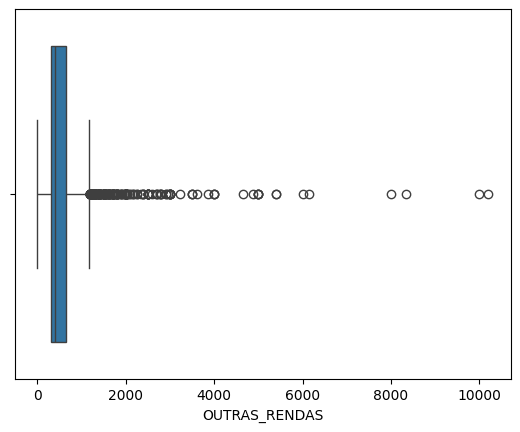

In [75]:
sns.boxplot(data=df.loc[(df.OUTRAS_RENDAS != 0) & (df.OUTRAS_RENDAS != 194344)],x="OUTRAS_RENDAS")

In [76]:
#Não tem como remover outliers porque a distribuição é bem instável, e ficaria apenas com zeros, e como a correlação é praticamente 0 com a target, vamos dropar a a coluna
df.drop("OUTRAS_RENDAS", axis=1, inplace=True)

## QUANT_CONTAS_BANCARIAS

In [77]:
df.QUANT_CONTAS_BANCARIAS.value_counts()

QUANT_CONTAS_BANCARIAS
0    32085
1    17832
2       14
Name: count, dtype: int64

In [78]:
aplicar_OHE.append('QUANT_CONTAS_BANCARIAS')

## QUANT_CONTAS_BANCARIAS_ESPECIAIS

In [79]:
df.QUANT_CONTAS_BANCARIAS_ESPECIAIS.value_counts()

QUANT_CONTAS_BANCARIAS_ESPECIAIS
0    32085
1    17832
2       14
Name: count, dtype: int64

In [80]:
# Verificando se é igual a coluna QUANT_CONTAS_BANCARIAS
df.loc[df["QUANT_CONTAS_BANCARIAS"] != df["QUANT_CONTAS_BANCARIAS_ESPECIAIS"]].value_counts()

Series([], Name: count, dtype: int64)

In [81]:
# Pelos valores serem os mesmo, optamos pro dropar essa coluna
df.drop("QUANT_CONTAS_BANCARIAS_ESPECIAIS",axis=1,inplace=True)

## VALOR_PATRIMONIO_PESSOAL

In [82]:
df.VALOR_PATRIMONIO_PESSOAL.describe().round(2)

count      49931.00
mean        2289.23
std        41849.25
min            0.00
25%            0.00
50%            0.00
75%            0.00
max      6000000.00
Name: VALOR_PATRIMONIO_PESSOAL, dtype: float64

In [83]:
len(df.loc[df.VALOR_PATRIMONIO_PESSOAL != 0])

2383

<Axes: xlabel='VALOR_PATRIMONIO_PESSOAL'>

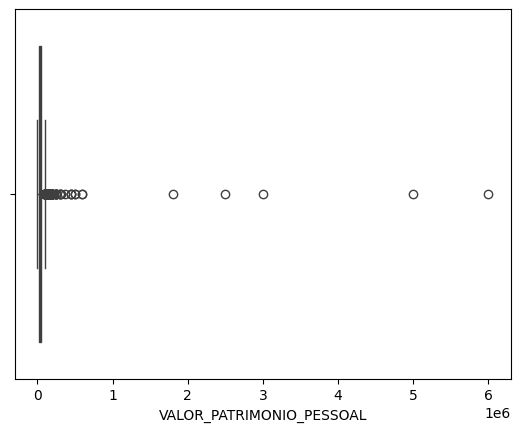

In [84]:
sns.boxplot(data=df.loc[(df.VALOR_PATRIMONIO_PESSOAL != 0) & (df.VALOR_PATRIMONIO_PESSOAL != 194344)],x="VALOR_PATRIMONIO_PESSOAL")

In [85]:
df['VALOR_PATRIMONIO_PESSOAL'].corr(df['ROTULO_ALVO_MAU_1'])

-0.003431148163664847

In [86]:
# O mesmo que ocorreu com a coluna OURAS_RENDA acontece com a coluna VALOR_PATRIMONIO_PESSOAL. A distribuição ;e bem instável e a correlaçao com a variavel alvo é praticamente 0, por esse motivo optamos pro dropar essa coluna 
df.drop("VALOR_PATRIMONIO_PESSOAL", axis=1, inplace=True)

## ESTADO_PROFISSIONAL

In [87]:
np.sort(df.ESTADO_PROFISSIONAL.unique())

array([' ', 'AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA',
       'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO',
       'RR', 'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

In [88]:
df.ESTADO_PROFISSIONAL.value_counts()

ESTADO_PROFISSIONAL
      34274
SP     2395
RS     2085
CE     1417
BA     1382
MG     1248
PE      900
PA      710
PR      580
RJ      570
MT      552
RN      491
GO      484
PB      373
MS      352
AL      337
SC      298
DF      267
ES      226
AP      186
MA      184
RO      170
AM      134
PI      100
AC       80
SE       62
TO       58
RR       16
Name: count, dtype: int64

In [89]:
df.loc[df['ESTADO_PROFISSIONAL'] == ' ', 'ESTADO_PROFISSIONAL'] = pd.NA
df.ESTADO_PROFISSIONAL.isna().sum()/df.shape[0]

0.6864272696320923

In [90]:
# Verificando a ausencia tanto na coluna ESTADO_PROFISSIONAL como na coluna CIDADE_PROFISSIONAL
linhas_faltantes_ambas = df[(df['ESTADO_PROFISSIONAL'].isna()) & (df['CIDADE_PROFISSIONAL'].isna())]
len(linhas_faltantes_ambas)

33750

In [91]:
# Como 68% do dados da Coluna ESTADO_PROFISSIONAL estão faltantes e torna a coluna inviavel de ser utilizada optamos por exclui-la
df.drop("ESTADO_PROFISSIONAL", axis=1, inplace=True)

## CIDADE_PROFISSIONAL

In [92]:
df.CIDADE_PROFISSIONAL.isna().sum()

33750

In [93]:
#Tratar NaN
df.CIDADE_PROFISSIONAL.isna().sum()/df.shape[0]

0.6759327872464

In [94]:
# Ocorre o mesmo que com a coluna anterior ESTADO_PROFISSIONAL
df.drop("CIDADE_PROFISSIONAL", axis=1, inplace=True)

## BAIRRO_PROFISSIONAL

In [95]:
df.BAIRRO_PROFISSIONAL.isna().sum()

33750

In [96]:
df.BAIRRO_PROFISSIONAL.isna().sum()/df.shape[0]

0.6759327872464

In [97]:
# Ocorre o mesmo que com as colunas  ESTADO_PROFISSIONAL e CIDADE_PROFISSIONAL
df.drop("BAIRRO_PROFISSIONAL", axis=1, inplace=True)

## CODIGO_AREA_TELEFONE_PROFISSIONAL

In [98]:
df.CODIGO_AREA_TELEFONE_PROFISSIONAL.value_counts()

CODIGO_AREA_TELEFONE_PROFISSIONAL
       36495
5       1453
54      1106
107      978
97       644
       ...  
55         1
96         1
19         1
37         1
17         1
Name: count, Length: 87, dtype: int64

In [99]:
df.loc[df['CODIGO_AREA_TELEFONE_PROFISSIONAL'] == ' ', 'CODIGO_AREA_TELEFONE_PROFISSIONAL'] = pd.NA
df.CODIGO_AREA_TELEFONE_PROFISSIONAL.isna().sum()/df.shape[0]

0.7309086539424405

In [100]:
# 73% dos dados faltante.
df.drop("CODIGO_AREA_TELEFONE_PROFISSIONAL", axis=1, inplace=True)

## MESES_NO_TRABALHO

In [101]:
df.MESES_NO_TRABALHO.value_counts()

MESES_NO_TRABALHO
0     49855
2        18
1        15
3        12
5         6
4         4
8         2
12        2
18        2
7         2
14        2
6         2
10        1
30        1
9         1
19        1
32        1
27        1
26        1
35        1
15        1
Name: count, dtype: int64

In [102]:
df['ROTULO_ALVO_MAU_1'].corr(df['MESES_NO_TRABALHO'])

-0.007075976726483518

In [103]:
df.drop("MESES_NO_TRABALHO", axis=1, inplace=True)

A coluna MESES_NO_TRABALHO apresenta uma distribuição altamente desbalanceada, com o valor 0 dominando em quase todas as observações (99,95%). Isso sugere que a maior parte dos indivíduos não possui meses de trabalho registrados. A baixa variabilidade da coluna não contribui para o modelo.

## CODIGO_PROFISSAO

In [104]:
df.CODIGO_PROFISSAO.isna().sum()

7751

In [105]:
df.CODIGO_PROFISSAO.value_counts()

CODIGO_PROFISSAO
9.0     30045
11.0     3542
0.0      3532
2.0      2826
12.0      489
10.0      425
16.0      342
13.0      313
7.0       213
8.0       144
6.0       136
15.0       63
17.0       35
4.0        27
3.0        18
5.0        12
14.0        9
1.0         8
18.0        1
Name: count, dtype: int64

In [106]:
df.CODIGO_PROFISSAO.isna().sum()/df.shape[0]

0.15523422322805472

In [107]:
df['ROTULO_ALVO_MAU_1'].corr(df['CODIGO_PROFISSAO'])

-0.011598171099811852

In [108]:
# Como a correlação com a variavel alvo é quase irrelevante e possui 15% de dados nulos, preferimos por dropar a coluna
df.drop("CODIGO_PROFISSAO", axis=1, inplace=True)

## TIPO_OCUPACAO

In [109]:
df.TIPO_OCUPACAO.isna().sum()

7305

In [110]:
df.TIPO_OCUPACAO.value_counts()

TIPO_OCUPACAO
2.0    16922
1.0     8734
4.0     6996
5.0     6877
0.0     2779
3.0      318
Name: count, dtype: int64

In [111]:
df['ROTULO_ALVO_MAU_1'].corr(df['TIPO_OCUPACAO'])

0.04033645691882448

In [112]:
# Como a correlaçao é fraca porém maior que a correlacao entre a variavel alvo e a coluna  CODIGO_PROFISSAO, optamos por preencher os valores nulos com "nao informado" para evitar perda de informação.
df.TIPO_OCUPACAO.fillna("nao informado", inplace=True)

In [113]:
(df['TIPO_OCUPACAO'].value_counts(normalize=True) * 100)

TIPO_OCUPACAO
2.0              33.890769
1.0              17.492139
nao informado    14.630190
4.0              14.011336
5.0              13.773007
0.0               5.565681
3.0               0.636879
Name: proportion, dtype: float64

In [114]:
aplicar_RL['TIPO_OCUPACAO'] = 0.1
aplicar_OHE.append("TIPO_OCUPACAO")

## CODIGO_PROFISSAO_CONJUGE

In [115]:
df.CODIGO_PROFISSAO_CONJUGE.isna().sum()

28854

In [116]:
df.CODIGO_PROFISSAO_CONJUGE = df.CODIGO_PROFISSAO_CONJUGE.astype("Int64")
df.CODIGO_PROFISSAO_CONJUGE.value_counts()

CODIGO_PROFISSAO_CONJUGE
0     13602
11     6001
9      1031
16      207
2       110
12       34
10       31
6        16
13       15
7        11
8         7
15        3
17        3
14        2
5         1
1         1
3         1
4         1
Name: count, dtype: Int64

In [117]:
df['ROTULO_ALVO_MAU_1'].corr(df['CODIGO_PROFISSAO_CONJUGE'])


-0.03503219202548166

In [118]:
df.CODIGO_PROFISSAO_CONJUGE.isna().sum()/df.shape[0]

0.5778774709098556

In [119]:
# Possui muitos valores faltantes e a correlaçao com a variavel alvo é muito baixa
df.drop("CODIGO_PROFISSAO_CONJUGE", axis=1, inplace=True)

## NIVEL_EDUCACIONAL_CONJUGE

In [120]:
df.NIVEL_EDUCACIONAL_CONJUGE.isna().sum()

32305

In [121]:
df.NIVEL_EDUCACIONAL_CONJUGE.value_counts()

NIVEL_EDUCACIONAL_CONJUGE
0.0    15964
3.0      618
4.0      615
2.0      341
1.0       56
5.0       32
Name: count, dtype: int64

In [122]:
df.NIVEL_EDUCACIONAL_CONJUGE = df.NIVEL_EDUCACIONAL_CONJUGE.astype("Int64")

In [123]:
df['ROTULO_ALVO_MAU_1'].corr(df['NIVEL_EDUCACIONAL_CONJUGE'])

-0.03255461834643098

In [124]:
df.NIVEL_EDUCACIONAL_CONJUGE.isna().sum()/df.shape[0]

0.6469928501331838

In [125]:
# Possui muitos valores faltantes assim como na coluna anterios e a correlaçao com a variavel alvo é muito baixa
df.drop("NIVEL_EDUCACIONAL_CONJUGE", axis=1, inplace=True)


## PRODUTO

In [126]:
df.PRODUTO.value_counts()

PRODUTO
1    42631
2     6007
7     1293
Name: count, dtype: int64

In [127]:
aplicar_OHE.append("PRODUTO")

## IDADE

In [128]:
df.IDADE.value_counts().head(20)

IDADE
39    1293
36    1283
40    1267
37    1266
41    1249
31    1240
32    1239
35    1238
34    1237
38    1233
43    1222
28    1213
42    1199
33    1194
30    1160
44    1156
45    1114
29    1099
46    1088
27    1075
Name: count, dtype: int64

In [129]:
df.IDADE.describe()

count    49931.000000
mean        43.248583
std         14.992260
min          6.000000
25%         31.000000
50%         41.000000
75%         53.000000
max        106.000000
Name: IDADE, dtype: float64

In [130]:
# Excluir Outliers Usando o Método de Z-score:

# 1. Calcular a média e o desvio padrão da coluna
mean = df['IDADE'].mean()
std = df['IDADE'].std()

# 2. Calcular o Z-score para cada valor da coluna
z_scores = (df['IDADE'] - mean) / std

# 3. Filtrar somente os outliers (Z-score > 3 ou Z-score < -3)
outliers = df[np.abs(z_scores) > 3]

# Exibir os outliers
print(len(outliers))

# removendo os outliers do df
df = df[np.abs(z_scores) <= 3]

82


In [131]:
df.IDADE.describe()

count    49849.000000
mean        43.167546
std         14.869905
min          6.000000
25%         31.000000
50%         41.000000
75%         53.000000
max         88.000000
Name: IDADE, dtype: float64

In [132]:
aplicar_RL['IDADE'] = 0.01
aplicar_CF.append("IDADE")

## CEP_RESIDENCIAL_3

In [133]:
df.CEP_RESIDENCIAL_3.unique()

array([595, 230, 591, ..., '337', '240', 802], dtype=object)

In [134]:
df['CEP_RESIDENCIAL_3'] = df['CEP_RESIDENCIAL_3'].astype(str)

In [135]:
df.CEP_RESIDENCIAL_3.value_counts()

CEP_RESIDENCIAL_3
960        1085
591         835
570         759
628         669
456         662
           ... 
301           1
907           1
408           1
674           1
#DIV/0!       1
Name: count, Length: 794, dtype: int64

In [136]:
df.loc[df.CEP_RESIDENCIAL_3 == '#DIV/0!', 'CEP_RESIDENCIAL_3'] = 'None'

In [137]:
aplicar_RL['CEP_RESIDENCIAL_3'] = 0.01
aplicar_CF.append("CEP_RESIDENCIAL_3")

## CEP_PROFISSIONAL_3

In [138]:
df.CEP_PROFISSIONAL_3.unique()

array([595, 230, 591, ..., '337', '240', 802], dtype=object)

In [139]:
df['CEP_PROFISSIONAL_3'] = df['CEP_PROFISSIONAL_3'].astype(str)

In [140]:
df.CEP_PROFISSIONAL_3.value_counts()

CEP_PROFISSIONAL_3
960        1085
591         835
570         759
628         669
456         662
           ... 
301           1
907           1
408           1
674           1
#DIV/0!       1
Name: count, Length: 794, dtype: int64

In [141]:
df.loc[df.CEP_PROFISSIONAL_3 == '#DIV/0!', 'CEP_PROFISSIONAL_3'] = 'None'

In [142]:
# Verificando se ela é igual a coluna CEP_RESIDENCIAL_3
len(df.loc[df["CEP_PROFISSIONAL_3"] != df["CEP_RESIDENCIAL_3"]])

0

In [143]:
# Excluir a coluna por conter os mesmo valores que a coluna CEP_RESIDENCIAL_3
df.drop("CEP_PROFISSIONAL_3",axis=1,inplace=True)

## ROTULO_ALVO_MAU_1

In [144]:
df.ROTULO_ALVO_MAU_1.value_counts()

ROTULO_ALVO_MAU_1
0    36863
1    12986
Name: count, dtype: int64

In [145]:
# Trasnformar em categorica
df.ROTULO_ALVO_MAU_1 = df.ROTULO_ALVO_MAU_1.astype('category')

# Matriz de Correlação

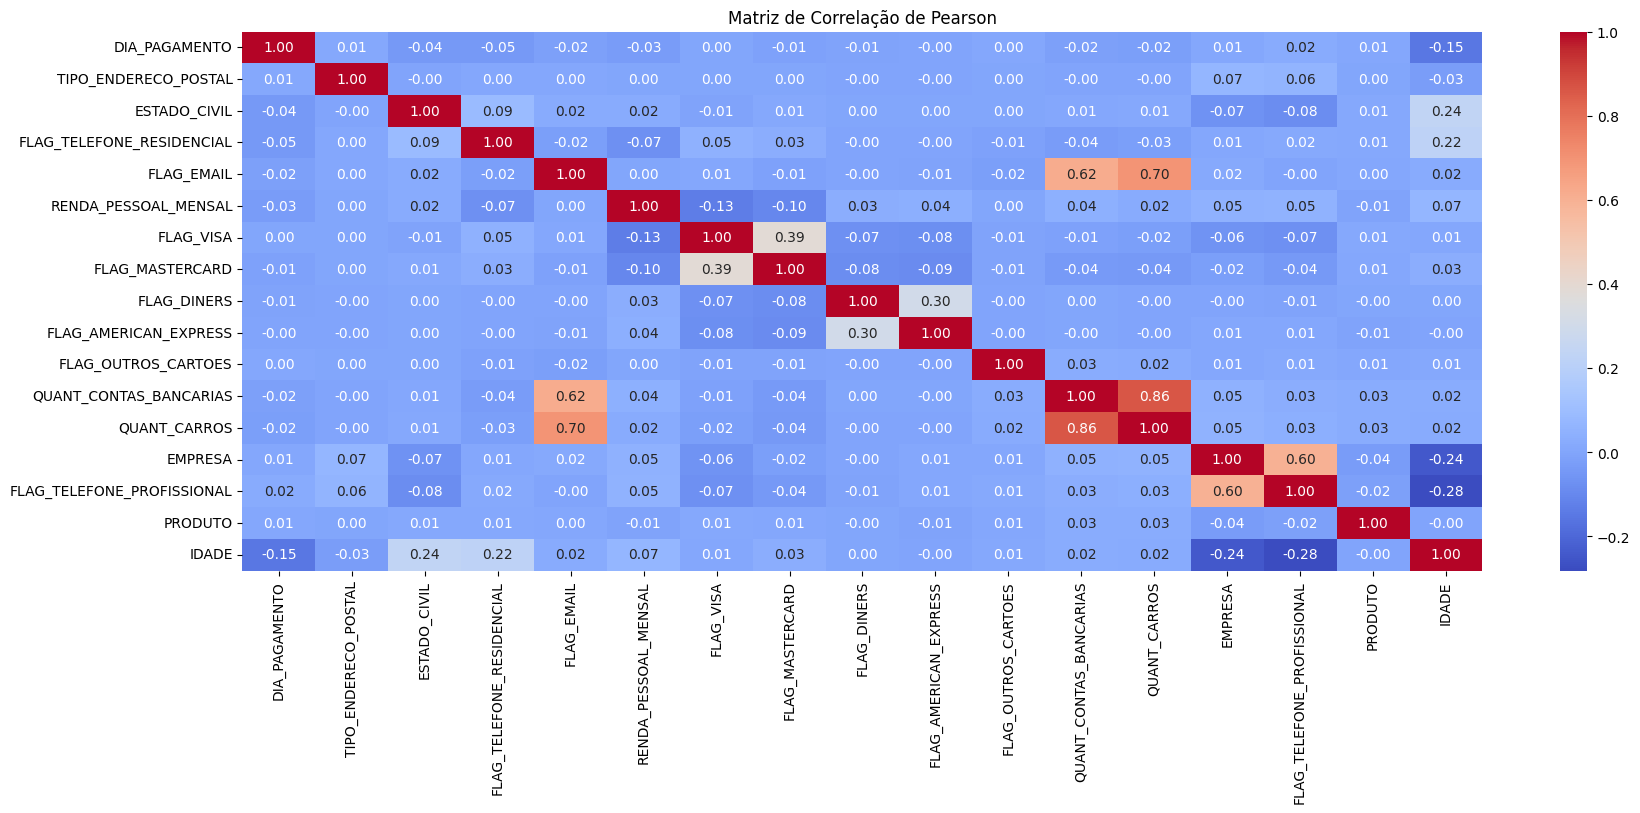

In [146]:
# Visualizar a matriz de correlação usando um heatmap
plt.figure(figsize=(20, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação de Pearson')
plt.show()

# Encoding

## Rare Label

In [147]:
aplicar_RL

{'DIA_PAGAMENTO': 0.1,
 'ESTADO_CIVIL': 0.03,
 'ESTADO_NASCIMENTO': 0.07,
 'ESTADO_RESIDENCIAL': 0.07,
 'CIDADE_RESIDENCIAL': 0.015,
 'BAIRRO_RESIDENCIAL': 0.05,
 'TIPO_RESIDENCIA': 0.03,
 'TIPO_OCUPACAO': 0.1,
 'IDADE': 0.01,
 'CEP_RESIDENCIAL_3': 0.01}

In [148]:
import pandas as pd
from feature_engine.encoding import RareLabelEncoder

chaves = list(aplicar_RL.keys())

# Converter as colunas para o tipo object (categórico)
df[chaves] = df[chaves].astype('object')


# Instanciar o RareLabelEncoder
for col, tol in aplicar_RL.items():
    encoder = RareLabelEncoder(tol=tol, replace_with='Rare', variables=[col])
    df = encoder.fit_transform(df)


# Visualizar as primeiras linhas do DataFrame atualizado
df.head()

,DIA_PAGAMENTO,TIPO_ENVIO_APLICACAO,TIPO_ENDERECO_POSTAL,SEXO,ESTADO_CIVIL,QUANT_DEPENDENTES,ESTADO_NASCIMENTO,ESTADO_RESIDENCIAL,CIDADE_RESIDENCIAL,BAIRRO_RESIDENCIAL,...,FLAG_OUTROS_CARTOES,QUANT_CONTAS_BANCARIAS,QUANT_CARROS,EMPRESA,FLAG_TELEFONE_PROFISSIONAL,TIPO_OCUPACAO,PRODUTO,IDADE,CEP_RESIDENCIAL_3,ROTULO_ALVO_MAU_1
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,5,Web,False,F,6,0,Rare,Rare,Rare,centro,...,False,0,False,False,False,4.0,1,32,Rare,1
2,15,Carga,False,F,2,NaN,Rare,Rare,Rare,Rare,...,False,0,False,True,False,4.0,1,34,Rare,1
3,5,Web,False,F,2,NaN,Rare,Rare,Rare,Rare,...,False,0,False,False,False,nao informado,1,27,591,0
4,20,Web,False,F,2,NaN,PE,PE,Rare,Rare,...,False,0,False,False,False,nao informado,1,61,Rare,0
5,10,Web,False,M,2,NaN,Rare,Rare,Rare,Rare,...,False,0,False,False,False,5.0,1,48,Rare,1


## Count Frequency

In [149]:
aplicar_CF

['ESTADO_NASCIMENTO',
 'ESTADO_RESIDENCIAL',
 'CIDADE_RESIDENCIAL',
 'BAIRRO_RESIDENCIAL',
 'IDADE',
 'CEP_RESIDENCIAL_3']

In [150]:
for col in aplicar_CF:
    frequency_counts = df[col].value_counts()
    df[col] = df[col].map(frequency_counts)

## One-Hot Encoding

In [151]:
aplicar_OHE

['DIA_PAGAMENTO',
 'TIPO_ENVIO_APLICACAO',
 'SEXO',
 'ESTADO_CIVIL',
 'QUANT_DEPENDENTES',
 'TIPO_RESIDENCIA',
 'MESES_RESIDENCIA',
 'QUANT_CONTAS_BANCARIAS',
 'TIPO_OCUPACAO',
 'PRODUTO']

In [152]:
df = pd.get_dummies(df, columns=aplicar_OHE, prefix=aplicar_OHE)
df.head()

,TIPO_ENDERECO_POSTAL,ESTADO_NASCIMENTO,ESTADO_RESIDENCIAL,CIDADE_RESIDENCIAL,BAIRRO_RESIDENCIAL,FLAG_TELEFONE_RESIDENCIAL,FLAG_EMAIL,RENDA_PESSOAL_MENSAL,FLAG_VISA,FLAG_MASTERCARD,...,TIPO_OCUPACAO_0.0,TIPO_OCUPACAO_1.0,TIPO_OCUPACAO_2.0,TIPO_OCUPACAO_3.0,TIPO_OCUPACAO_4.0,TIPO_OCUPACAO_5.0,TIPO_OCUPACAO_nao informado,PRODUTO_1,PRODUTO_2,PRODUTO_7
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
1,False,20845,22621,41319,4926,False,False,900.0,False,False,...,False,False,False,False,True,False,False,True,False,False
2,False,20845,22621,41319,44923,False,False,750.0,True,True,...,False,False,False,False,True,False,False,True,False,False
3,False,20845,22621,41319,44923,False,False,500.0,True,True,...,False,False,False,False,False,False,True,True,False,False
4,False,4081,3657,41319,44923,True,False,500.0,True,True,...,False,False,False,False,False,False,True,True,False,False
5,False,20845,22621,41319,44923,False,False,1200.0,True,True,...,False,False,False,False,False,True,False,True,False,False


# Modelo Regressão Logistica

In [153]:
# Importar bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Preparar o Dataset

# Definir a variável alvo (exemplo: 'STATUS_PAGAMENTO' onde 1 = bom pagador, 0 = mau pagador)
y = df['ROTULO_ALVO_MAU_1']  # Substitua pelo nome correto da sua coluna alvo

# Definir as variáveis preditoras (X)
X = df.drop(columns=['ROTULO_ALVO_MAU_1'])  # Retiramos a variável alvo das variáveis preditoras

# 2. Dividir o Dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Treinar o Modelo de Regressão Logística
modelo = LogisticRegression(max_iter=1000)  # max_iter aumentado para garantir convergência
modelo.fit(X_train, y_train)

# 4. Fazer previsões e avaliar a performance
y_pred = modelo.predict(X_test)

# Avaliar a performance
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test,y_pred))

Acurácia: 0.7391507856904046

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85     11062
           1       0.38      0.00      0.01      3893

    accuracy                           0.74     14955
   macro avg       0.56      0.50      0.43     14955
weighted avg       0.64      0.74      0.63     14955


Matriz de Confusão:
 [[11042    20]
 [ 3881    12]]
